<a href="https://colab.research.google.com/github/BlueBlazin/nlp_from_ground_up/blob/master/rnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import plotly.express as px
import tensorflow_datasets as tfds

First, some basic functions.

In [ ]:
def softmax(x):
    x -= np.max(x)
    x = np.exp(x)
    return x / np.sum(x)

In [ ]:
def cross_entropy(t, pred):
    target = np.zeros_like(pred)
    target[t] = 1
    return -np.sum(target * np.log(pred))

In [ ]:
def loss_fn(ts, ys):
    return sum(cross_entropy(t, y) for t, y in zip(ts, ys)) / len(ts)

The vanilla RNN is just $\mathbf{h_t} = \text{tanh}(\mathbf{W_x} \mathbf{x_t} + \mathbf{W_h} \mathbf{h_{t-1}} + \mathbf{b_h})$.

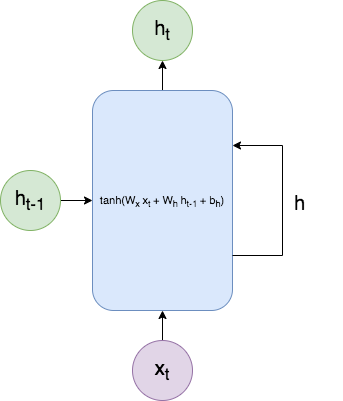

In [ ]:
def rnn_cell(x, hprev, Wx, Wh, bh):
    return np.tanh(Wx @ x + Wh @ hprev + bh)

In [ ]:
def forward_pass(xs, h, Wx, Wh, bh, Wy, by):
    hs = []
    ys = []

    for x in xs:
        h = rnn_cell(x, h, Wx, Wh, bh)
        hs.append(h)

        y = softmax(Wy @ h + by)
        ys.append(y)

    return ys, hs

#### Backward Pass

When it comes to writing backpropagation by hand it's helpful to be explicit by drawing the computation graph in steps of simple operations.

Note: If the emphasis is on simple operations, why the `cross_ent(softmax(r_t))` step? That's because that entire operation has a very simple gradient (explained below).

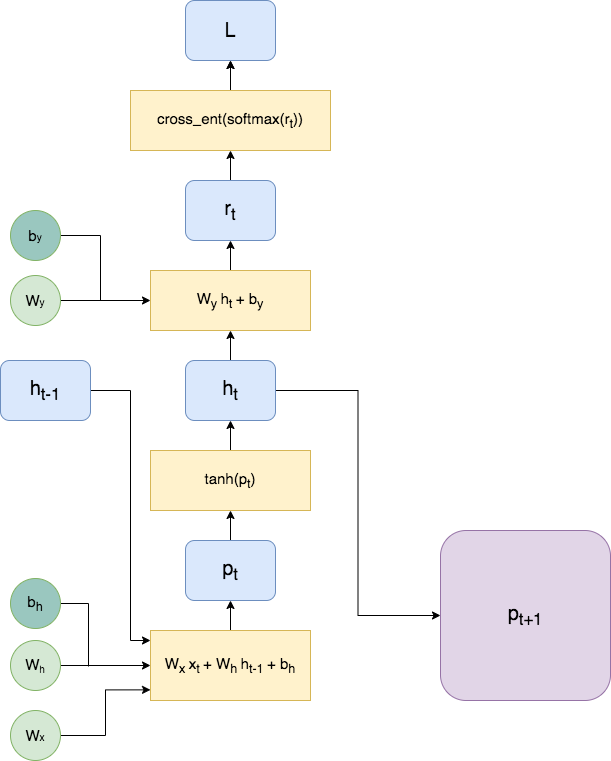

In [ ]:
def backward_pass(xs, ys, hs, ts, Wy, by, Wx, Wh, bh):
    dWy = np.zeros_like(Wy)
    dby = np.zeros_like(by)

    dWx = np.zeros_like(Wx)

    dWh = np.zeros_like(Wh)
    dbh = np.zeros_like(bh)

    dpnext = np.zeros_like(hs[0])

    for t in reversed(range(len(ys))):
        y = ys[t]
        h = hs[t]
        x = xs[t]
        hprev = hs[t - 1]

        dr = y.copy()
        dr[ts[t]] -= 1

        dh = Wy.T @ dr + Wh @ dpnext

        dWy += dr @ h.T
        dby += dr

        dp = (1 - h * h) * dh

        dWx += dp @ x.T

        dWh += dp @ hprev.T
        dbh += dp

        dpnext = dp.copy()

    return dWy, dby, dWx, dWh, dbh

In [ ]:
xs = [np.array([[1, 0, 0, 0]]).T, np.array([[0, 1, 0, 0]]).T, np.array([[0, 0, 1, 0]]).T]

ts = [1, 2, 3]

Wx = np.random.randn(3, 4)

Wh = np.random.randn(3, 3)
bh = np.random.randn(3, 1)

Wy = np.random.randn(4, 3)
by = np.random.randn(4, 1)

hzero = np.zeros((3, 1))

In [ ]:
alpha = 0.01
losses = []

for i in range(5000):
    ys, hs = forward_pass(xs, hzero, Wx, Wh, bh, Wy, by)
    hs.append(hzero)

    losses.append(loss_fn(ts, ys))

    if i % 500 == 0:
        print(losses[-1])

    dWy, dby, dWx, dWh, dbh = backward_pass(xs, ys, hs, ts, Wy, by, Wx, Wh, bh)

    Wy -= alpha * dWy
    by -= alpha * dby

    Wx -= alpha * dWx

    Wh -= alpha * dWh
    bh -= alpha * dbh

3.7165258105053987
0.16487008820292678
0.04930454054309454
0.02752508198542869
0.018853571976271705
0.014268143963098015
0.011451608864807769
0.009552947504467512
0.00818919395776365
0.007163499086960842


In [ ]:
df = pd.DataFrame({'Epoch': range(len(losses)), 'Loss': losses})
fig = px.line(df, x="Epoch", y="Loss", title='Training loss')
fig.show()

In [ ]:
dataset = tfds.load(name='tiny_shakespeare')['train']

In [ ]:
def one_hot(k):
    enc = np.zeros((256, 1))
    enc[k, 0] = 1
    return enc

In [ ]:
def xavier(shape):
    width = 1 / np.sqrt(shape[-1])
    return np.random.uniform(-width, width, size=shape)

In [ ]:
hidden_dim = 64
vocab_size = 256
size = 25
alpha = 0.001
num_epochs = 3
mu = 0.5

In [ ]:
Wx = xavier((hidden_dim, vocab_size))

Wh = xavier((hidden_dim, hidden_dim))
bh = xavier((hidden_dim, 1))

Wy = xavier((vocab_size, hidden_dim))
by = xavier((vocab_size, 1))

In [ ]:
v_Wx = np.zeros_like(Wx)

v_Wh = np.zeros_like(Wh)
v_bh = np.zeros_like(bh)

v_Wy = np.zeros_like(Wy)
v_by = np.zeros_like(by)

In [16]:
i = 0
losses = []

for epoch in range(num_epochs):
    if i > 100_000:
        break

    for record in dataset.batch(1):
        if i > 100_000:
            break

        line = list(record['text'].numpy()[0])

        hzero = np.zeros_like(bh)

        for t in range(0, len(line) - size - 1):
            xs = line[t:t + size]
            xs = [one_hot(k) for k in xs]

            ts = line[t + 1:t + size + 1]

            ys, hs = forward_pass(xs, hzero, Wx, Wh, bh, Wy, by)
            hs.append(hzero)

            if i % 10_000 == 0:
                losses.append(loss_fn(ts, ys))
                print(f"Loss at step {i}: {losses[-1]}")

            dWy, dby, dWx, dWh, dbh = backward_pass(xs, ys, hs, ts, Wy, by, Wx, Wh, bh)

            v_Wy = mu * v_Wy - alpha * dWy
            Wy += v_Wy

            v_by = mu * v_by - alpha * dby
            by += v_by

            v_Wx = mu * v_Wx - alpha * dWx
            Wx += v_Wx

            v_Wh = mu * v_Wh - alpha * dWh
            Wh += v_Wh

            v_bh = mu * v_bh - alpha * dbh
            bh += v_bh

            hzero = hs[-2]  # the last h_t will be the next hzero
            i += 1

Loss at step 0: 5.664782094696687
Loss at step 1000: 3.430226369468835
Loss at step 2000: 3.2277665952095487
Loss at step 3000: 3.088047194384032
Loss at step 4000: 3.0626593515639886
Loss at step 5000: 2.3418635665717513
Loss at step 6000: 1.8930584403825828
Loss at step 7000: 2.281093663439014
Loss at step 8000: 2.9619345281591993
Loss at step 9000: 2.544291394381429
Loss at step 10000: 2.2095948006264625
Loss at step 11000: 2.2959918095200953
Loss at step 12000: 2.332242758364172
Loss at step 13000: 2.4875573726871645
Loss at step 14000: 2.6769324947758686
Loss at step 15000: 1.8622942565818186
Loss at step 16000: 1.872707768810173
Loss at step 17000: 2.205791925930757
Loss at step 18000: 2.5042832870395126
Loss at step 19000: 2.7213628278580466
Loss at step 20000: 1.7862474172750549
Loss at step 21000: 2.3669561080874804
Loss at step 22000: 1.8391054201049268
Loss at step 23000: 2.159749207689472
Loss at step 24000: 1.9734710245597527
Loss at step 25000: 1.851129849386196
Loss at s

KeyboardInterrupt: ignored

In [17]:
df = pd.DataFrame({'Epoch': range(len(losses)),
                   'Loss': losses,
                   'Running Avg Loss': np.convolve(losses, np.ones(10)/10, mode='valid')})

fig = px.line(df, x="Step", y="Loss")
fig = px.line(df, x="Step", y="Running Avg Loss")
fig.show()

ValueError: ignored

In [18]:
h = np.zeros_like(bh)
sentence = ['T']
x = ord(sentence[0])

for _ in range(140):
    h = rnn_cell(one_hot(x), h, Wx, Wh, bh)
    y = Wy @ h + by

    x = np.argmax(y[:, 0])
    sentence.append(chr(x))

print("".join(sentence))

There the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the
